In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
df=image_dataset_from_directory(
     "C:/Users/rajs1/Potato Data",
      seed=123,
      image_size=(256,256),
      batch_size=32,
      validation_split=0.2,
      subset='training'
)
val_df=image_dataset_from_directory(
     "C:/Users/rajs1/Potato Data",
      seed=123,
      image_size=(256,256),
      batch_size=32,
      validation_split=0.2,
      subset='validation'
)

Found 2630 files belonging to 3 classes.
Using 2104 files for training.
Found 2630 files belonging to 3 classes.
Using 526 files for validation.


In [3]:
class_names=df.class_names
class_names

['Pepper__bell___healthy - Copy', 'Potato___Early_blight', 'Potato___healthy']

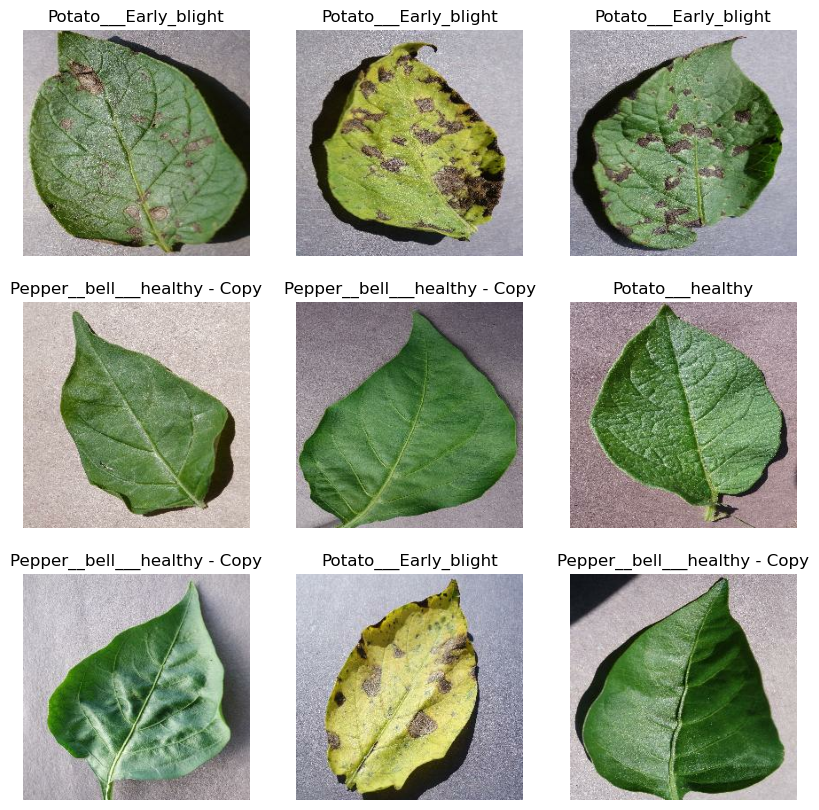

In [4]:
import matplotlib.pyplot as plt

for img, label in df.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(img[i].numpy().astype("uint8"))
        plt.title(class_names[label[i].numpy()])
        plt.axis('off')
    plt.show()
    break

    


In [5]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras.models import Sequential

Re_layer = Rescaling(1./255)

Aug_data = Sequential([
    RandomRotation(0.2),
    RandomFlip("horizontal_and_vertical")
])


In [6]:
df = df.map(lambda x, y: (Aug_data(Re_layer(x)), y))

In [7]:
for i,j in df:
    print(i.numpy().shape)
    break;

(32, 256, 256, 3)


In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

model = Sequential([

    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.15),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax') 
])


C:\Users\rajs1\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(
    df,
    epochs=5,
    batch_size=32,
    validation_data=val_df
)


Epoch 1/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 256s 4s/step - accuracy: 0.5418 - loss: 2.1566 - val_accuracy: 0.8270 - val_loss: 35.5949
Epoch 2/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.8754 - loss: 0.3943 - val_accuracy: 0.8536 - val_loss: 57.1909
Epoch 3/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 333s 4s/step - accuracy: 0.9018 - loss: 0.3559 - val_accuracy: 0.9030 - val_loss: 23.9813
Epoch 4/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 326s 4s/step - accuracy: 0.9092 - loss: 0.2744 - val_accuracy: 0.8631 - val_loss: 45.1877
Epoch 5/5
66/66 ━━━━━━━━━━━━━━━━━━━━ 327s 4s/step - accuracy: 0.8969 - loss: 0.3127 - val_accuracy: 0.8935 - val_loss: 6.0203


In [15]:
df_test = image_dataset_from_directory(
    "C:/Users/rajs1/Test",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)



Found 300 files belonging to 3 classes.


In [16]:
df_test= df_test.map(lambda x, y: (Aug_data(Re_layer(x)), y))

In [17]:
test_loss, test_accuracy = model.evaluate(df_test)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.0717 - loss: 2.9227
Test Loss: 3.1574137210845947
Test Accuracy: 0.06666667014360428


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


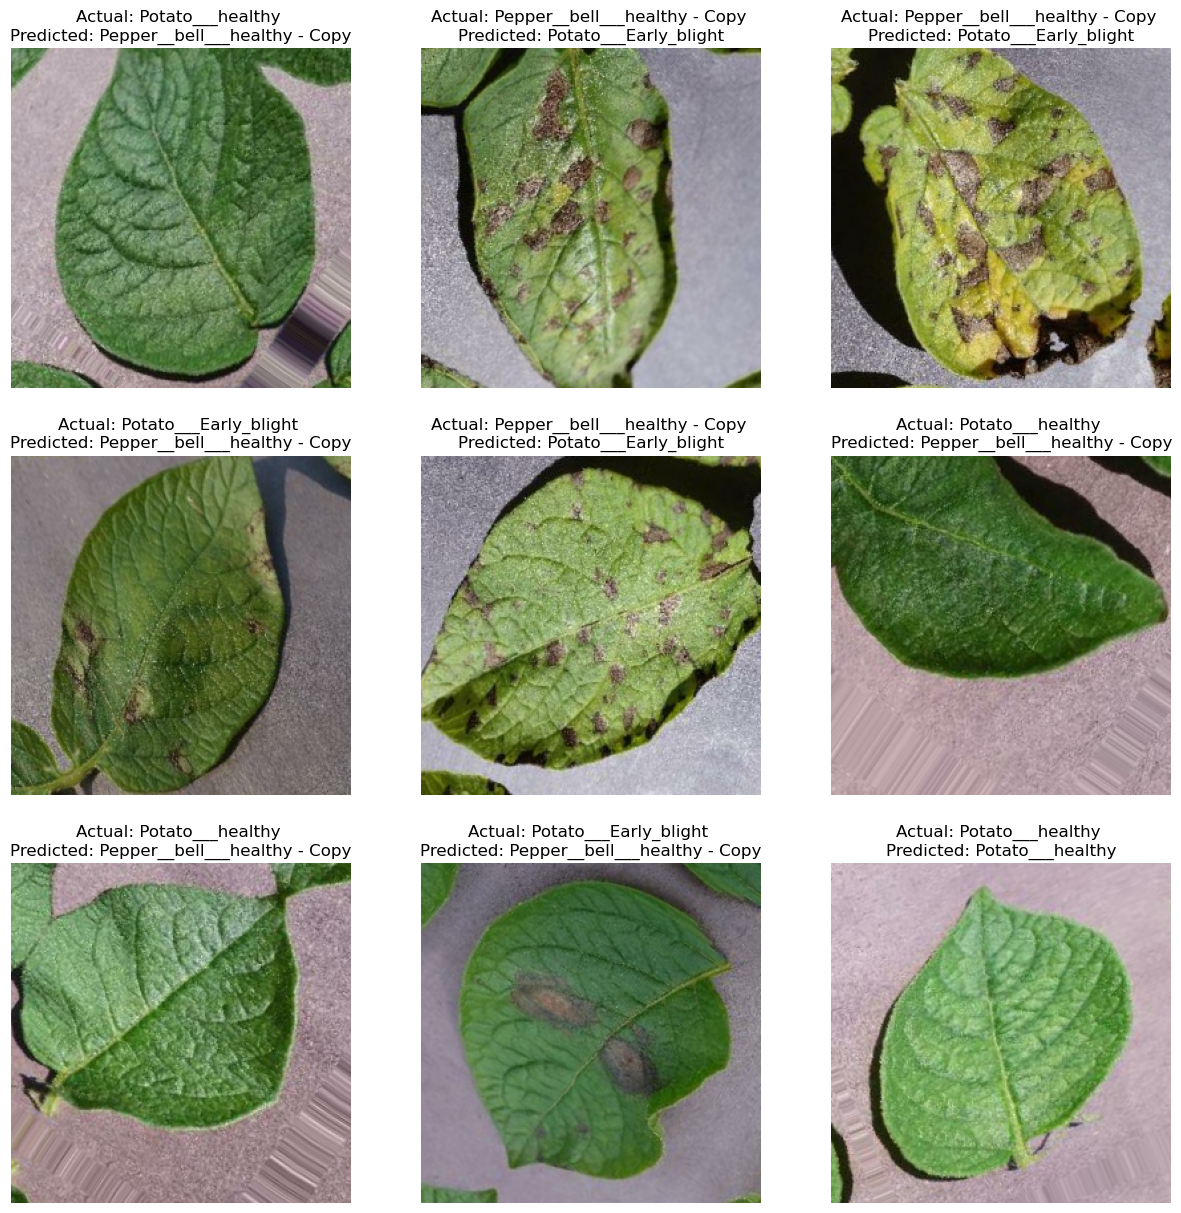

In [20]:
for images, actual_labels in df_test.take(1):
    predictions = model.predict(images)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(15, 15))
    max_images = min(len(images), 9)
    for i in range(max_images):
        plt.subplot(3, 3, i + 1)
        
        image_display = images[i].numpy()
        if image_display.max() <= 1.0:
            image_display = (image_display * 255).astype("uint8")
            
        plt.imshow(image_display)
        plt.title(f'Actual: {class_names[actual_labels[i].numpy()]} \nPredicted: {class_names[predicted_labels[i].numpy()]}')
        plt.axis('off')

    plt.show()
    break



In [24]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
for layer in base_model.layers:
    layer.trainable = False

model2 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])


In [ ]:
from tensorflow.keras.optimizers import Adam

model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model2.fit(
    df,
    epochs=5,
    validation_data=val_df,
    batch_size=32
)

Epoch 1/5
